In [3]:
reqjsons = {}

In [24]:
import requests
import time
import numpy as np

def reqjson(url):
    if url in reqjsons:
        return reqjsons[url]
    headers = {
        'Accept': 'application/json'
    }
    response = requests.get(url, headers=headers)
    reqjsons[url] = response.json()
    print(f"Downloaded {url}")
    time.sleep(0.5)
    return reqjsons[url]

In [5]:
koniun_przekroj = reqjson("https://api-sdp.stat.gov.pl/api/1.0.0/variable/variable-section-position?id-przekroj=803&lang=pl")
woje_names = [r["nazwa-pozycja"] for r in koniun_przekroj if r["id-wymiar"] == 4 and r["id-pozycja"] >= 33619]
woje_names

Downloaded https://api-sdp.stat.gov.pl/api/1.0.0/variable/variable-section-position?id-przekroj=803&lang=pl


['MAŁOPOLSKIE',
 'ŚLĄSKIE',
 'LUBUSKIE',
 'WIELKOPOLSKIE',
 'ZACHODNIOPOMORSKIE',
 'DOLNOŚLĄSKIE',
 'OPOLSKIE',
 'KUJAWSKO-POMORSKIE',
 'POMORSKIE',
 'WARMIŃSKO-MAZURSKIE',
 'ŁÓDZKIE',
 'ŚWIĘTOKRZYSKIE',
 'LUBELSKIE',
 'PODKARPACKIE',
 'PODLASKIE',
 'MAZOWIECKIE']

In [6]:
koniun_przekroj = reqjson("https://api-sdp.stat.gov.pl/api/1.0.0/variable/variable-section-position?id-przekroj=803&lang=pl")
woje = [r["id-pozycja"] for r in koniun_przekroj if r["id-wymiar"] == 4 and r["id-pozycja"] >= 33619]
woje

[33619,
 33929,
 34187,
 34353,
 34815,
 35067,
 35390,
 35542,
 35786,
 35976,
 36185,
 36450,
 36627,
 36924,
 37185,
 37380]

In [25]:
def get_gus_array(zm,przk,okr,additional={}):
    bezrob = []
    for rok in range(2013,2023):
        if (rok > 2020 and zm == 365 and przk == 1164):
            zm = 1507
            przk = 1360

        koniund = reqjson(f"https://api-sdp.stat.gov.pl/api/1.0.0/variable/variable-data-section?id-zmienna={zm}&id-przekroj={przk}&id-rok={rok}&id-okres={okr}&page-size=5000&page=0&lang=pl")

        def selectos(d,k):
            matches = [r for r in d if k.items() <= r.items()]
            if len(matches) > 1:
                raise Exception("Ambiguous")
            return matches[0]

        bezrob.extend([selectos(koniund["data"], {
                'id-zmienna': zm,
                'id-przekroj': przk,
                'id-pozycja-1': w,
                "id-okres": okr,
                **additional
            })["wartosc"] for w in woje])

    return np.array(bezrob)

In [39]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

ludnosc = get_gus_array(365, 1164, 273, {"id-pozycja-2": 6704418})

X = np.column_stack([
                     get_gus_array(1339, 2, 282),                                       # \item Inwestycje długoterminowe przedsiębiorstw niefinansowych o liczbie pracujących 10 i więcej osób, prowadzących księgi rachunkowe, zł per capita
                     get_gus_array(1284, 29, 277, {"id-pozycja-2": 660772}),            # \item Udział liczby przedsiębiorstw wykazujących zysk netto w ogólnej liczbie przedsiębiorstw niefinansowych o liczbie pracujących 50 i więcej osób, prowadzących księgi rachunkowe, całoroczny
                     get_gus_array(376, 2, 269, {"id-sposob-prezentacji-miara": 243}),  # \item Przeciętne miesięczne wynagrodzenie brutto w sektorze przedsiębiorstw, całoroczny
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6661753}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: handel detaliczny, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6662701}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: handel hurtowy, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6971707}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: budownictwo, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6971711}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: działalność związana z zakwaterowaniem i usługami gastronomicznymi, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6971735}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: informacja i komunikacja, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6971739}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: transport i gospodarka magazynowa, grudzień danego roku
                     get_gus_array(184, 803, 258, {"id-pozycja-2": 6971743}),           # \item Wskaźnik ogólnego klimatu koniunktury, sektor: przetwórstwo przemysłowe, grudzień danego roku
                     get_gus_array(875, 143, 258),                                      # \item Stopa bezrobocia rejestrowanego, grudzień danego roku
                     get_gus_array(305, 737, 277, {"id-pozycja-2": 6656078}),           # \item Wskaźniki cen towarów i usług konsumpcyjnych, całoroczny (analogiczny okres roku poprzedniego=100)
                     ])

np.set_printoptions(formatter=dict(float='{:f}'.format))

X[:,0] = X[:,0]/ludnosc

print(ludnosc[-1])
print(type(X[-1,:]))
print(X[-1,:])

col_max = np.max(np.abs(X), axis=0)
X = X / col_max
X[:,-1] = 1-X[:,-1]
X[:,-2] = 1-X[:,-2]

def cost_fun(omega):
    return -1*sum(np.corrcoef(col, X @ omega)[1,0] for col in X.T)

omega_0 = np.array([1/X.shape[1]] * X.shape[1])
print(omega_0)

constraints = ({'type': 'eq', 'fun': lambda omega: np.sum(omega) - 1},
               {'type': 'ineq', 'fun': lambda omega: omega})

# Minimalizacja wektora omega
res = minimize(cost_fun, omega_0, constraints=constraints,
               options={"maxiter": 100, "disp": True})

print(res)

4468.0
<class 'numpy.ndarray'>
[49297.100045 82.200000 7699.780000 -9.200000 -3.800000 -16.500000
 -1.400000 7.500000 -2.300000 -2.400000 4.300000 113.500000]
[0.083333 0.083333 0.083333 0.083333 0.083333 0.083333 0.083333 0.083333
 0.083333 0.083333 0.083333 0.083333]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.591043935198672
            Iterations: 20
            Function evaluations: 281
            Gradient evaluations: 20
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5.591043935198672
       x: [ 6.620e-02  3.254e-01  7.531e-02  2.673e-02  2.736e-02
            3.337e-02  3.486e-02  3.041e-02  3.557e-02  3.335e-02
            5.582e-02  2.556e-01]
     nit: 20
     jac: [-2.566e-03  1.815e-04 -2.142e-03  8.806e-04  1.409e-03
           -2.081e-03  4.163e-03  4.695e-03 -1.434e-03  1.912e-03
           -1.255e-03  1.901e-04]
    nfev: 281
    njev: 20


In [43]:
print(woje_names[np.argmax(X @ res.x)%16],2013+np.argmax(X @ res.x)//16,np.max(X @ res.x))
print(woje_names[np.argmin(X @ res.x)%16],2013+np.argmin(X @ res.x)//16,np.min(X @ res.x))
np.argmax(X @ res.x)%16

MAZOWIECKIE 2018 0.5125592202412295
ŚWIĘTOKRZYSKIE 2022 0.25794766605093966


15

C:\Users\Jakub\AppData\Local\Temp\ipykernel_36980\4096388187.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Jakub\AppData\Local\Temp\ipykernel_36980\4096388187.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Jakub\AppData\Local\Temp\ipykernel_36980\4096388187.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Jakub\AppData\Local\Temp\ipykernel_36980\4096388187.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


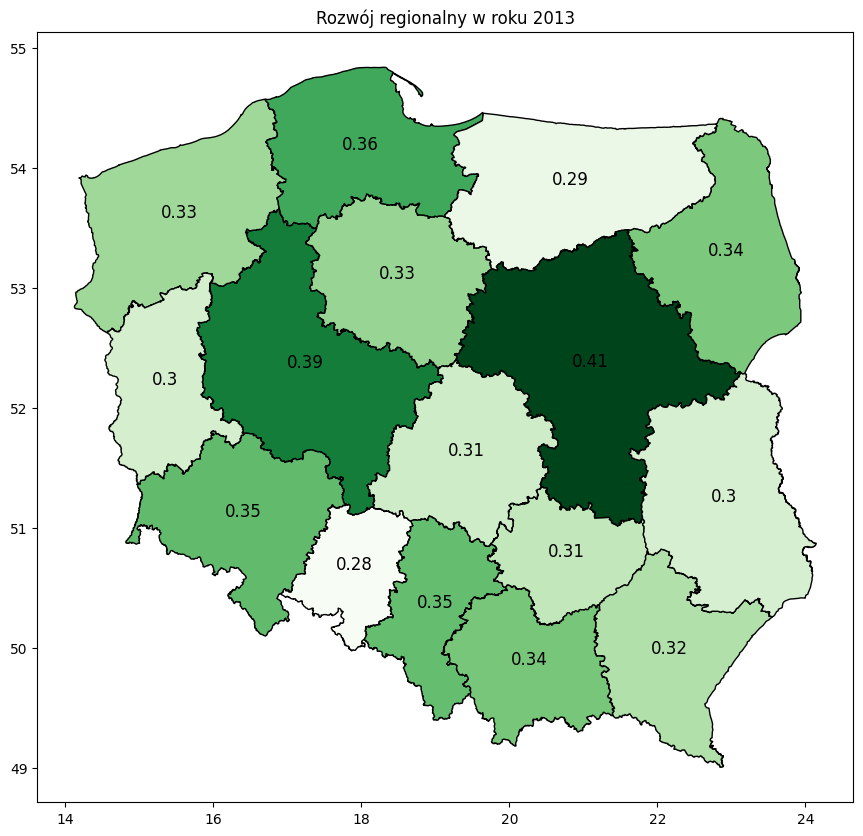

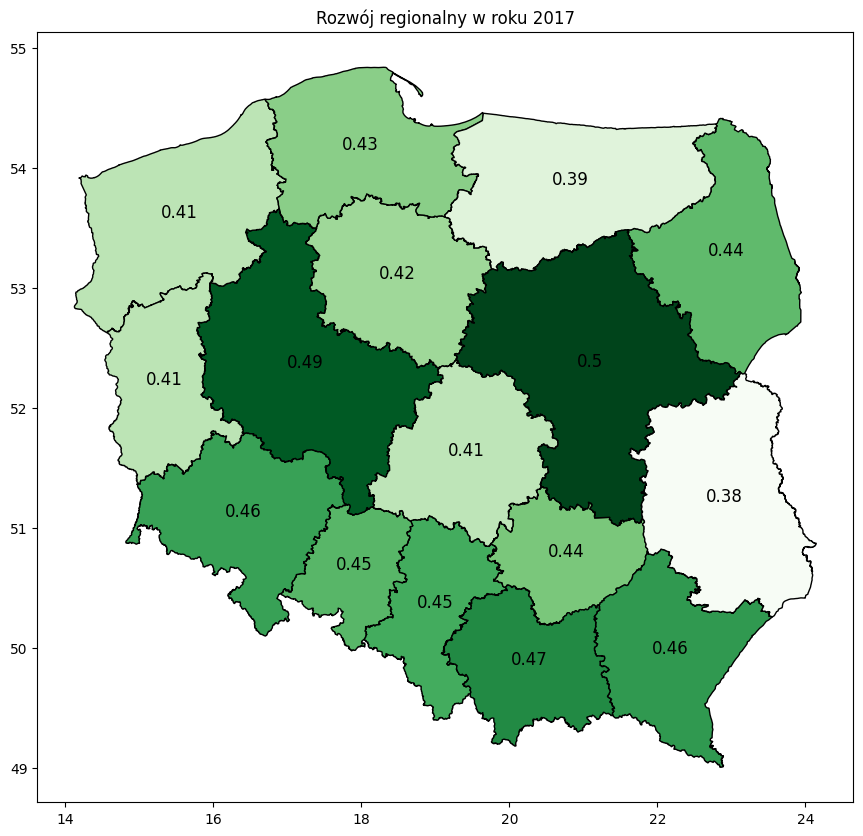

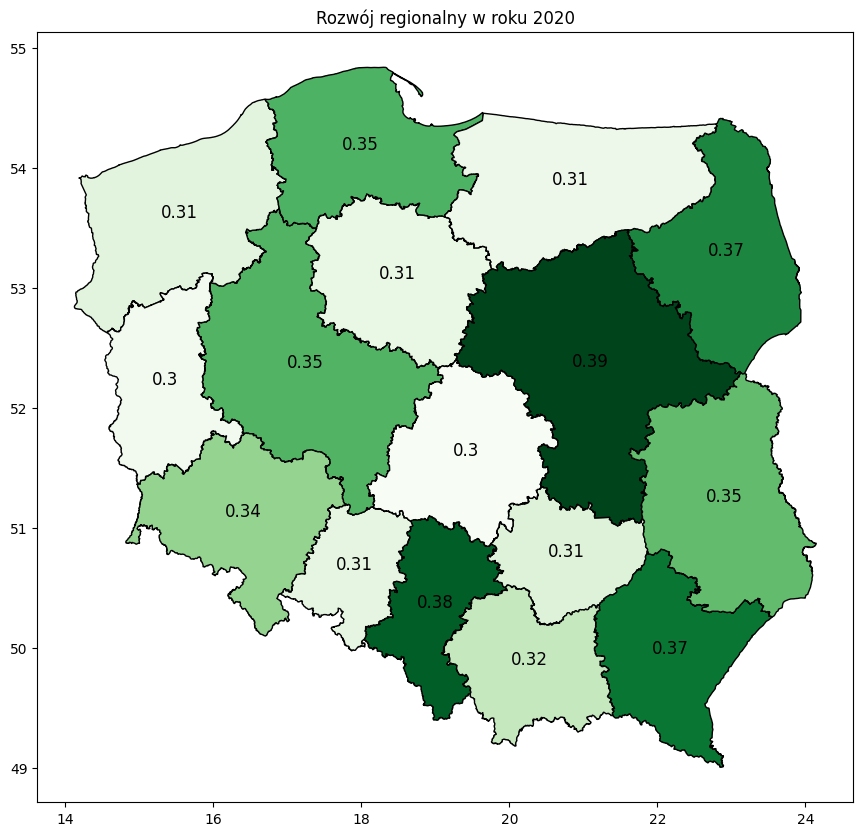

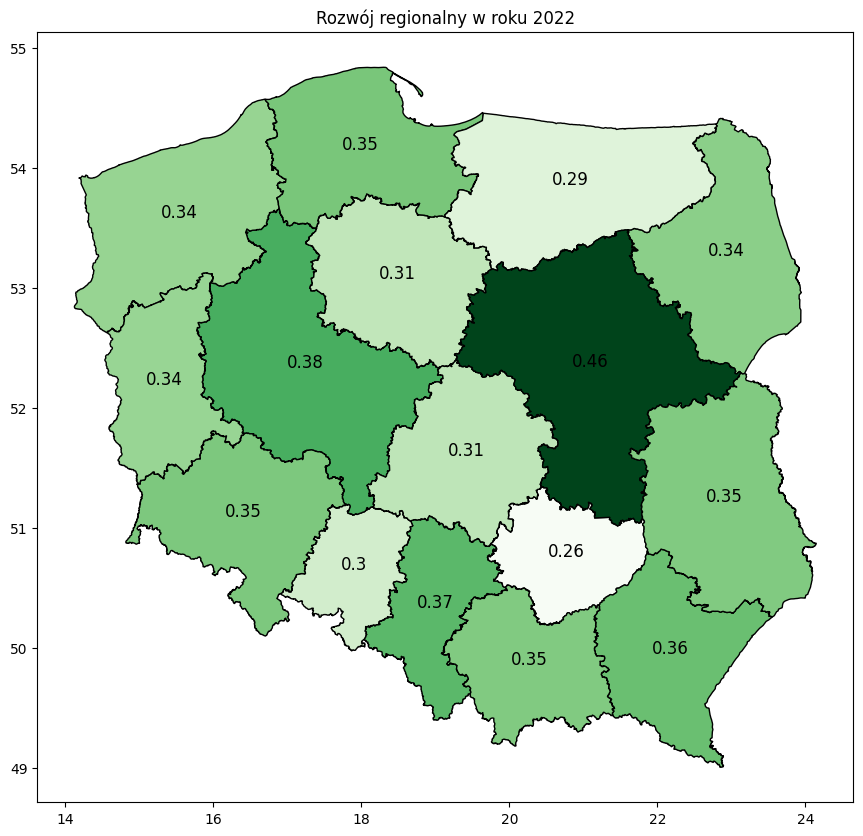

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('wojewodztwa.geojson.txt')

SK = X @ res.x

wojmap = [
    "śląskie", "opolskie", "wielkopolskie", "zachodniopomorskie", "świętokrzyskie", "kujawsko-pomorskie", "podlaskie", "dolnośląskie", "podkarpackie", "małopolskie",
    "pomorskie", "warmińsko-mazurskie", "łódzkie", "mazowieckie", "lubelskie", "lubuskie"
    ]

for yearr in [2013,2017,2020,2022]:
    SK2 = [SK[(yearr-2013)*16+woje_names.index(wojmap[i].upper())] for i in range(16)]

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    gdf['SK'] = SK2
    gdf.plot(ax=ax, column='SK', cmap='Greens', edgecolor='black')

    for idx, row in gdf.iterrows():
        plt.annotate(text=f'{row["SK"]:.2g}', xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                    horizontalalignment='center', fontsize=12, color='black')

    ax.set_title(f'Rozwój regionalny w roku {yearr}')
    fig.savefig(f"rozw{yearr}")
    fig.show()


In [66]:
wojsk = [SK[w:160:16] for w in range(16)]
np.argmax(np.std(wojsk,axis=1))
woje_names[12]

'LUBELSKIE'

C:\Users\Jakub\AppData\Local\Temp\ipykernel_36980\3038875054.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


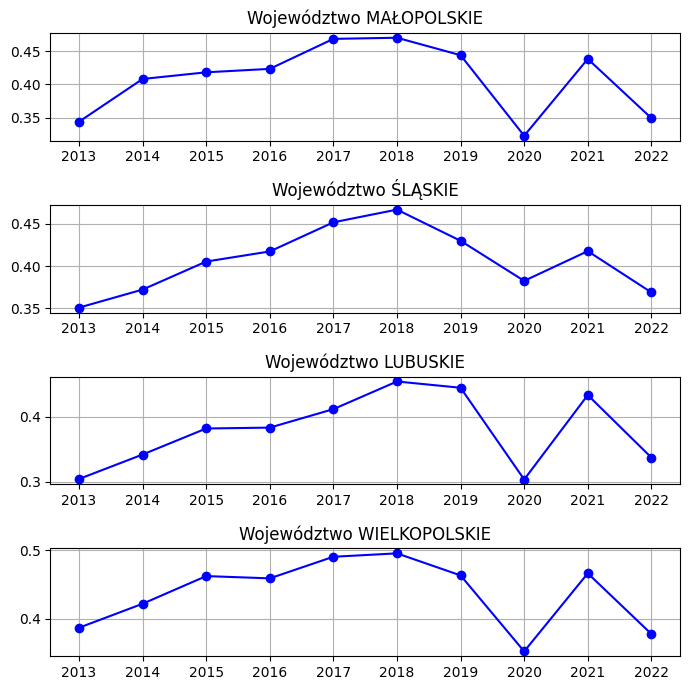

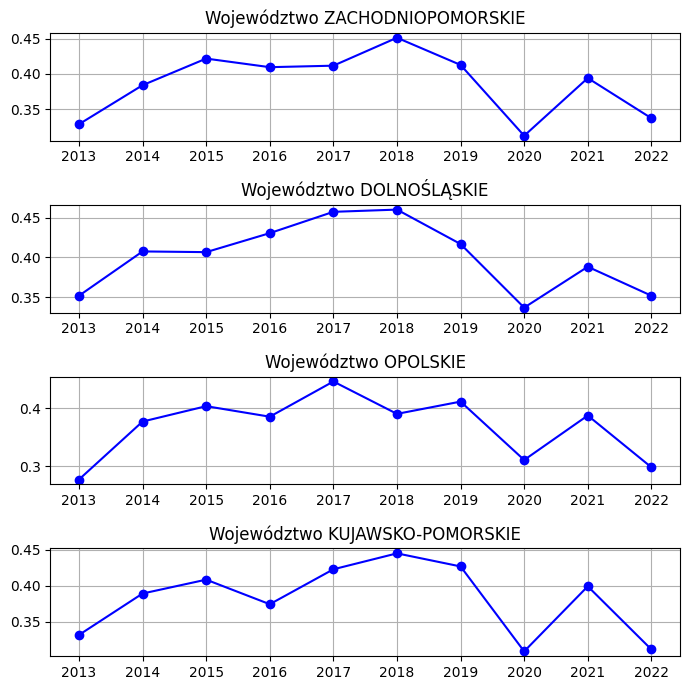

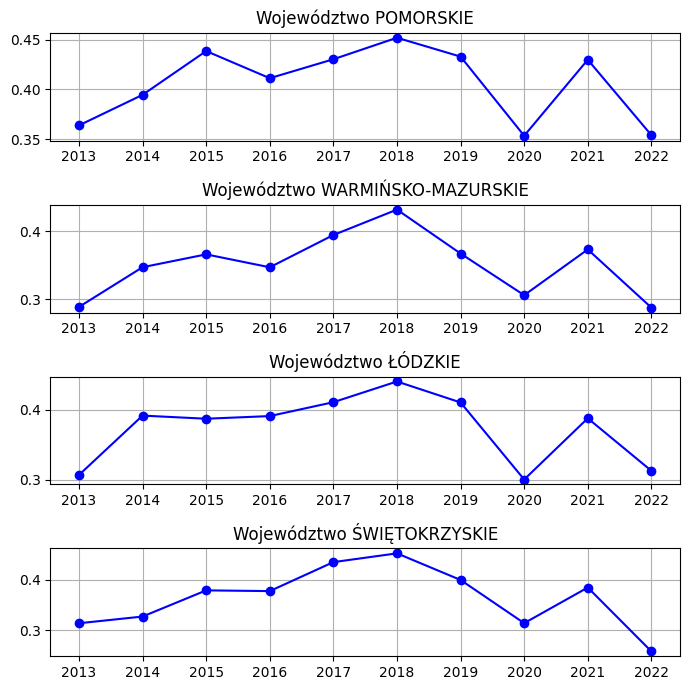

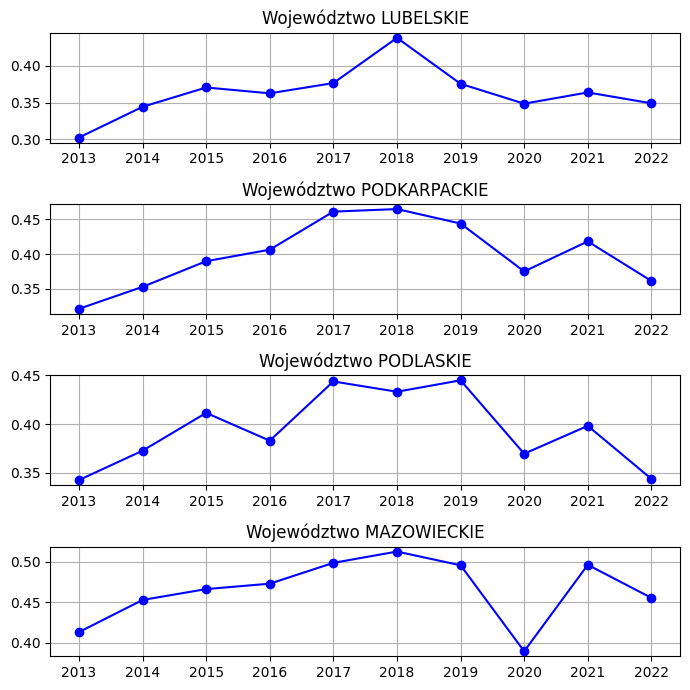

In [46]:
for k in range(4):
    fig, ax = plt.subplots(4,1,figsize=(7, 7),squeeze=False)

    for i in range(4):
        for j in range(1):
            w = k*4+i*1+j
            ax[i,j].plot(range(2013,2023),SK[w:160:16], marker='o', linestyle='-', color='b')
            ax[i,j].set_xticks(range(2013,2023))
            ax[i,j].grid(True)
            ax[i,j].set_title(f"Województwo {woje_names[w]}")

    fig.tight_layout()
    fig.savefig(f"lines{k}.png")
    fig.show()